# Loading Image Data
In the previous notebooks, we used PyTorch's datasets which were nicely formatted for use out of the box. In this notebook we will learn how to store our own custom images and load them for use.

In [1]:
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim

import matplotlib.pyplot as plt
from collections import OrderedDict

Define some transforms for both training and test sets. Random transformations should be applied to the training set to help a network better generalize. The validation set should be resized, cropped and normalized the same as the training data. However, the random augmentations should not be added to the validation set. 

In [2]:
# Training set
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

random_ts =  transforms.RandomApply([transforms.RandomHorizontalFlip(),
                                     transforms.RandomGrayscale(),
                                     transforms.RandomPerspective(),
                                     transforms.RandomVerticalFlip()])

augment = transforms.Compose([random_ts, 
                              transform,
                              transforms.Normalize([0.5, 0.5, 0.5],
                                                   [0.5, 0.5, 0.5])])

In [3]:
trainset = datasets.ImageFolder('data/Cat_Dog_data/train/', transform=augment)
testset = datasets.ImageFolder('data/Cat_Dog_data/test/', transform=transform)

In [4]:
trainload = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testload = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [5]:
images, labels = iter(trainload).next()
image = images[0]
image.shape

torch.Size([3, 224, 224])

`matplotlib` requires that the channels be described in the 3rd dimension, so we must permute our image tensor to get it to display correctly using `plt.imshow`:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


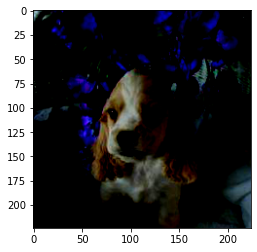

In [6]:
image = image.permute(1, 2, 0)
plt.imshow(image.numpy())

# Transfer Learning
A fully connected network with random initialized weights is probably not up to the task of classifying these dog and cat images. Instead, we will use pre-trained networks that have done the majority of the training we need already. We'll then refine these pre-trained networks to our specific use. 

We need to use the same normalization parameters as when the models were trained. We will change those here:

In [7]:
# Revamped Data augmentation                                
augment = transforms.Compose([random_ts, 
                              transform,
                              transforms.Normalize([0.485, 0.456, 0.406],
                                                   [0.229, 0.224, 0.225])])

And re-initialize our training and validation `DataLoaders`:

In [8]:
trainset = datasets.ImageFolder('data/Cat_Dog_data/train/', transform=augment)
testset = datasets.ImageFolder('data/Cat_Dog_data/test/', transform=transform)

trainload = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testload = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=4)

Lets get a pretrained model and freeze its hidden layers:

In [9]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

And, we want to customize the classifier which makes up the final layers of the pre-trained network. This will allow us to use the network for our specific purposes.

In [10]:
classifier = nn.Sequential(OrderedDict(
    [('fc1', nn.Linear(2048, 512)),
     ('relu', nn.ReLU()),
     ('drop', nn.Dropout(p=0.2)),
     ('fc2', nn.Linear(512, 2)),
     ('smax_out', nn.LogSoftmax(dim=1))]
))

model.fc = classifier

Set the device to environment specific settings:

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [12]:
import time

In [20]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
epochs = 10

start = time.time()
train_loss = []
valid_loss = []

for e in range(epochs):
    
    steps = 0
    accuracy = 0
    running_tl = 0
    running_vl = 0
    
    # backprop and training
    for images, labels in trainload:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_tl += loss.item()
        steps += 1
        
    # Get validation error/accuracy for current epoch. 
    model.eval()
    with torch.no_grad():
        for images, labels in testload:
            images, labels = images.to('cuda'), labels.to('cuda')
            logps = model(images)
            ps = torch.exp(logps)
            loss = criterion(logps, labels)
            running_vl += loss.item()
            top_p, top_class = ps.topk(1, dim=1)
            equals = (top_class == labels.view(*top_class.shape)).cpu().numpy()
            accuracy += equals.mean()
        print(f'Test Accuracy: {accuracy/len(testload)}')

    model.train()
    valid_loss.append(running_vl/len(testload))       
    train_loss.append(running_tl/len(trainload))
        
print(f'Average time per epoch: {(time.time() - start)/epochs}')
    train_loss.append(running_tl/len(trainload))

Test Accuracy: 0.9173259493670886
Test Accuracy: 0.9078322784810127
Test Accuracy: 0.9169303797468354
Test Accuracy: 0.913370253164557
Test Accuracy: 0.8757911392405063
Test Accuracy: 0.9169303797468354
Test Accuracy: 0.9287974683544303
Test Accuracy: 0.9003164556962026
Test Accuracy: 0.935126582278481
Test Accuracy: 0.9018987341772152


Average time per batch: 182.536 seconds


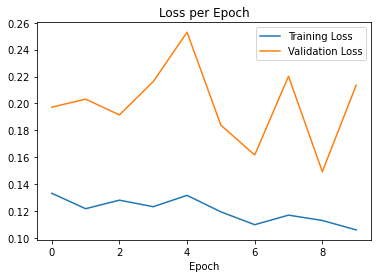

In [21]:
    
print(f'Average time per batch: {(time.time() - start)/epochs:.3f} seconds')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()